# Exercise 5: PyTorch and Convolutional Neural Networks (CNNs)

## PyTorch
PyTorch is a deep learning framework developed with numpy compatibility in mind. Many operations are designed to closely resemble those in numpy, but it is optimized for larger data structures and parallel processing with support for GPU acceleration. Additionally it contains many tools to perform common tasks in machine learning like data loaders, gradient-based optimization algorithms and basic building blocks for neural networks. 

To use PyTorch we need to import the `torch` package:

In [1]:
import torch

### Tensors

`torch.Tensor` is the fundamental data structure in PyTorch. Operations are applied to tensors and return a tensor as a result. A tensor can be created from a list, tuple or multidimendional numpy array using the `torch.tensor()` function: 

In [2]:
import numpy as np

a = np.array([[1,2,3],
              [4,5,6]])

b = torch.tensor(a)
print(b.size())
print(b)

torch.Size([2, 3])
tensor([[1, 2, 3],
        [4, 5, 6]])


Array indexing and arithmetics work the same as with numpy arrays:

In [3]:
# Adding and multiplying with broadcasting
c = b * 3 + 5
print(c)

# Element-wise add of two tensors
d = b + c
print(d)

print(d[1,1:])

tensor([[ 8, 11, 14],
        [17, 20, 23]])
tensor([[ 9, 13, 17],
        [21, 25, 29]])
tensor([25, 29])


Additionally to a data type, tensors also contain information about which device they reside on. It can either be system memory or the memory of a GPU.

__Important note__:
Current pytorch binary releases only support GPUs with CUDA compute compatibility 3.5+. At the time of writing, pool PCs in most pools only have CUDA compute compatibility 3.0 capable hardware (which is still reported as `torch.cuda.is_available() = True` but fails on many operations with an error message). If you encounter CUDA or cuDNN related errors, manually set `use_gpu = False` here to force computations to use the CPU instead.

In [4]:
#device='cpu' creates the tensor in system memory, which is also the default
a = torch.tensor([[1, 3, 7], [2, 5, 3]], dtype=torch.float, device='cpu')
print(a)

#we can check if GPU support is available on the current machine and environment:
print(torch.cuda.is_available())
use_gpu = torch.cuda.is_available()

if use_gpu:
    #we can create a copy of the tensor on the default gpu
    b = a.cuda()
    print(b)
    #or we can explicitly specify which device to use
    c = a.cuda(0)
    print(c)
    #we can specify the gpu as target during initialization
    d = torch.tensor([[1, 3, 7], [2, 5, 3]], dtype=torch.float, device='cuda:0')
    print(d)
    #and we can create a copy on the cpu
    e = d.cpu()
    print(e)

tensor([[1., 3., 7.],
        [2., 5., 3.]])
True
tensor([[1., 3., 7.],
        [2., 5., 3.]], device='cuda:0')
tensor([[1., 3., 7.],
        [2., 5., 3.]], device='cuda:0')
tensor([[1., 3., 7.],
        [2., 5., 3.]], device='cuda:0')
tensor([[1., 3., 7.],
        [2., 5., 3.]])


Operations on multiple tensors (e.g. add) require the tensors to reside on the same device.

A list of basic tensor operations can be found here: https://pytorch.org/docs/stable/tensors.html

### Autograd

PyTorch tensors keep track of how they were created and all basic operations contain information of what their derivative looks like. If we want to calculate the derivative of a result with respect to an input, we can create the input tensor with `requires_grad=True` and propagate the differentiation back to the beginning of the calculation:

In [5]:
a = torch.tensor([2, 3], dtype=torch.float, requires_grad=True)
b = torch.tensor([5, 1], dtype=torch.float, requires_grad=True)

#elementwise multiplication
c = a*b
print(c)
#square all elements and add them
d = c.pow(2).sum()

print(d)

#calculate the derivative of d with respect to all elements of its inputs (recursively through backpropagation)
d.backward()

#the derivatives are stored in the input tensors
print(c.grad)#is None since c was implicitly created with requires_grad=False
print(b.grad)
print(a.grad)

tensor([10.,  3.], grad_fn=<MulBackward0>)
tensor(109., grad_fn=<SumBackward0>)
None
tensor([40., 18.])
tensor([100.,   6.])


Since `d` was created through arithmetic operations of other tensors, we can interpret it as a function that was evaluated with set parameters and calculate its derivative using the chain rule: 
$$
d = d(\vec{c}) = d(\vec{c}(\vec{a}, \vec{b}))\\
\frac{\partial{d}}{\partial{a_0}}{\bigg|}_{a=[2, 3], b=[5, 1]} = (2\cdot c_0)\cdot b_0 |_{a=[2, 3], b=[5, 1]} = (2 \cdot (a_0 \cdot b_0)) \cdot b_0|_{a=[2, 3], b=[5, 1]} = 100 = \mathrm{a.grad[0]}
$$

So if `d` was our loss function, we could use `a.grad` and `b.grad` to adjust `a` and `b` to minimize the loss iteratively.

Important note: The gradients need to be set to zero again before calling `.backward()` of another calculation involving `a` or `b`, otherwise they keep accumulating.

### Modules

In PyTorch the `Module` class is a container which aggregates operations and the parameters involved. This makes it easy to create reusable building blocks. For example we can define a MLP module like so:

In [6]:
import torch.nn.functional as F

class MLP(torch.nn.Module):
    #create all child-modules and parameters inside the initialization method
    def __init__(self, dim_in, dim_hidden, dim_out):
        super().__init__()
        #weight parameters with random initialization
        self.weights_hidden = torch.nn.Parameter(torch.randn((dim_in, dim_hidden), requires_grad=True))
        self.biases_hidden = torch.nn.Parameter(torch.zeros(dim_hidden, requires_grad=True))
        self.weights_out = torch.nn.Parameter(torch.randn((dim_hidden, dim_out), requires_grad=True))
        self.biases_out = torch.nn.Parameter(torch.zeros(dim_out, requires_grad=True))
        
    #the forward method defines how the child-modules and parameters should be used on some input 'tensor_in'
    #to generate the module output
    def forward(self, tensor_in):
        hidden_values = tensor_in.matmul(self.weights_hidden) + self.biases_hidden
        hidden_activations = F.relu(hidden_values)
        out_values = hidden_activations.matmul(self.weights_out) + self.biases_out
        return out_values

To train an MLP using stochastic gradient descent we can use the SGD implementation included in `torch.optim`:

In [7]:
#Create an instance of the MLP with input size 3, 10 hidden neurons and 2 output neurons
my_mlp = MLP(3, 10, 2)

#create an optimizer instance and tell it which paramters to optimize
optimizer = torch.optim.SGD(my_mlp.parameters(), lr=0.001)#learning rate of 0.001
#optimizers have a convenience function to set all parameter gradients back to zero - although this would not be necessary before the first .backward() call
optimizer.zero_grad()

input_tensor = torch.tensor([[1.5, 2.1, 5.1]])

#define the loss function
loss_func = torch.nn.CrossEntropyLoss()

#using a module instance like a function invokes its "forward"  method
prediction = my_mlp(input_tensor)

#calculate the cross-entropy loss if the label for the one sample given above is "1"
loss = loss_func(prediction, torch.tensor([1]))

#perform back propagation
loss.backward()

#perform one SGD step using the gradients stored in the parameters
optimizer.step()

A list of built-in neural network modules, like convolution layers, can be found here: https://pytorch.org/docs/stable/nn.html#conv2d

## EMNIST
The Extended-MNIST dataset consists of about a million grayscale images of handwritten digits, uppercase letters and lowercase letters (62 classes) with a size of 28x28 pixels. It is pre-split into a training-set and a test-set. Here is an example from the training set and its corresponding label:

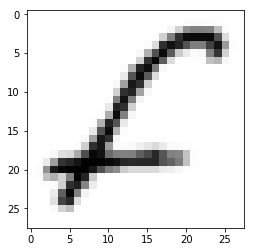

F


In [8]:
%matplotlib inline

from utils.utils_5 import EMNIST
import matplotlib.pyplot as plt
import numpy as np
import string

#create dataset object instances for the training and test set
train_set = EMNIST('data/emnist-byclass-train-images-idx3-ubyte', 'data/emnist-byclass-train-labels-idx1-ubyte')
test_set = EMNIST('data/emnist-byclass-test-images-idx3-ubyte', 'data/emnist-byclass-test-labels-idx1-ubyte')

#select an arbitrary index as an example
index = 689

#retrieve the image and label from the dataset
example_image, example_label = train_set.__getitem__(index)

#flip axis to get the right format for imshow
example_image = np.transpose(example_image)

#invert black/white to make it look like black ink on white paper (just for viewing convenience)
example_image = 255 - example_image

#display the example image
plt.imshow(example_image, cmap='gray')
plt.show()

#build the class names list
class_names = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)

#select the class name of the example's label
print(class_names[example_label])

## Exercise 5.1: Building a model for EMNIST classification
Now let's build a model to predict the class labels on the EMNIST dataset. 

We want to start with a simple model with only two convolution layers (`torch.nn.Conv2d`) with max pooling (`torch.nn.functional.max_pool2d`) and a linear layer (`toch.nn.Linear`) to create the class probabilities.

__Preparation__:
 - What is the width and height of the first convolution layer's output if it has a kernel size of 5 and no padding?
 - What is the width and height of the feature maps after the first pooling layer with a pooling size of 2?
 - What is the width and height of the feature maps after the second pooling layer?
 - If the second convolution layer generates 30 feature maps, how large is the input size of the linear layer?
 
__Programming Hints__:
 - Use the documentation linked above to see the arguments of the `Conv2d` and `Linear` modules.
 - Functions in `torch.nn.functional` are really just functions, not modules, so you don't need to create instances of them in `__init__`. They can be applied to tensors directly in `forward`.
 - We will not feed the module single samples, which would be tensors with dimensions `(1, 28, 28)` (the `1` is the number of color channels), but batches of samples with dimensions `(batch_size, 1, 28, 28)`. The modules and functions in `torch.nn` are all capable of processing batches. 
 - The loss function we use here (`torch.nn.CrossEntropyLoss`) implicitly applies softmax to the predictions so our model should not apply softmax to the output itself. Also since softmax is a monotonic function, finding the most likely class after softmax is equivalent to finding the highest scored entry before softmax.

In [9]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        feature_maps_1 = 20
        feature_maps_2 = 30
        
        num_classes = len(class_names)
        
        # TODO: initialize the child-modules
        self.conv1 = 
        self.conv2 = 

        self.fully_connected = 

    def forward(self, x):
        # TODO: apply the modules and functions
        feature_map_1_pre_activations = 
        feature_map_1_pre_pooling = 
        feature_map_1_post_pooling = 
        
        feature_map_2_pre_activations = 
        feature_map_2_pre_pooling = 
        feature_map_2_post_pooling = 
        
        feature_map_2_flattened = feature_map_2_post_pooling.flatten(start_dim=1)
        predictions_pre_softmax = 
        
        return predictions_pre_softmax

Now we want to train the model. You can try to tune the elements in the hyperparameter section to improve the test accuracy or change your model architecture. Training takes about 6500 batches per epoch for a batch size of 100.

Training on GPU
==>>> epoch: 0, test loss: 43.175031, test acc: 0.0081


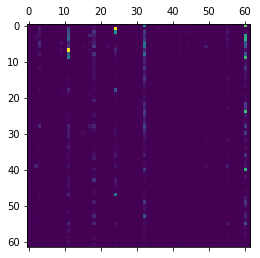

==>>> epoch: 0, batch index: 500, train loss: 0.730942, train acc: 0.6156
==>>> epoch: 0, batch index: 1000, train loss: 0.581653, train acc: 0.6895
==>>> epoch: 0, batch index: 1500, train loss: 0.752314, train acc: 0.7221
==>>> epoch: 0, batch index: 2000, train loss: 0.558538, train acc: 0.7408
==>>> epoch: 0, batch index: 2500, train loss: 0.446308, train acc: 0.7534
==>>> epoch: 0, batch index: 3000, train loss: 0.780958, train acc: 0.7626
==>>> epoch: 0, batch index: 3500, train loss: 0.465289, train acc: 0.7693
==>>> epoch: 0, batch index: 4000, train loss: 0.606736, train acc: 0.7746
==>>> epoch: 0, batch index: 4500, train loss: 0.626443, train acc: 0.7791
==>>> epoch: 0, batch index: 5000, train loss: 0.528576, train acc: 0.7826
==>>> epoch: 0, batch index: 5500, train loss: 0.506281, train acc: 0.7857
==>>> epoch: 0, batch index: 6000, train loss: 0.414322, train acc: 0.7887
==>>> epoch: 0, batch index: 6500, train loss: 0.553646, train acc: 0.7916
==>>> epoch: 1, test loss:

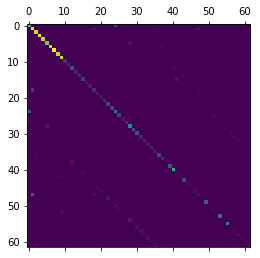

done


In [10]:
#Create an instance of our model
model = MyModel()

#Put the model on the GPU if available
if use_gpu:
    model = model.cuda()
    print("Training on GPU")
else:
    print("Training on CPU")

###
# Hyperparameters:
###

#Select a learning rate
lr=0.001

#Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#Select a loss function
loss_func = torch.nn.CrossEntropyLoss()

#Select a training batch size
batch_size = 100

#Select the number of training epochs
epochs = 1

###
# Training code:
###
%matplotlib inline
from utils.utils_5 import train, evaluate
from torch.utils.data import Dataset, DataLoader

#The DataLoader takes care of shuffling the dataset and serving batches
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

#Train for some epochs and calculate test accuracy once per epoch
for epoch in range(epochs):
    #test
    evaluate(epoch, model, loss_func, test_loader, use_gpu)
    
    #training
    train(epoch, model, loss_func, optimizer, train_loader, use_gpu)

#Perform a final evaluation
evaluate(epochs, model, loss_func, test_loader, use_gpu)
print('done')

### Related questions
The confusion matrix generated at the end of the training shows some distinctive features.
 - What does the distribution of brightness on the diagonal of the confusion matrix say about the dataset?
 - There is a faint diagonal line in the confusion matrix at $x \in [10\dots 36]$, $y \in [36\dots 62]$. What does it say about the labeling of the data?


To test your model's performance and robustness, here is an interactive canvas to draw inputs for the model to classify. 

In [11]:
import numpy as np
import torch

from utils.utils_5 import make_prediction_canvas

canvas_size = (280, 280)

def predict_func(img_data):
    #transform the list into a 2d array
    img_data = np.asarray(img_data, dtype=np.float32).reshape(*canvas_size)
    #transform the numpy array into a torch tensor
    x = torch.tensor(img_data, dtype=torch.float)
    #move it to the GPU is possible
    if use_gpu:
        x = x.cuda()
    #scale it down from 280x280 to 28x28 pixels using bilinear interpolation
    x = torch.nn.functional.interpolate(x.unsqueeze_(dim=0).unsqueeze_(dim=1), size=(28, 28), mode='bilinear').squeeze_(dim=1).squeeze_(dim=0)
    #flip dimensions to match dataset
    x = x.transpose(0, 1)
    #add a batch dimension with batch_size=1
    x.unsqueeze_(dim=0)
    #add a color dimension with color channel count=1
    x.unsqueeze_(dim=1)
    
    #switch model to evaluation mode (only necessary for some modules like dropout and batch normalization, but better to always have it rather than forget it when needed)
    model.eval()
    #predict the label for the input
    with torch.no_grad():#we don't want to store information for gradient computation
        out = model(x)
    #get the most likely label
    pred_label = out.argmax(1)
    pred_label = pred_label.item()
    #return the predicted class name to the HTML-framework (to be displayed below)
    return class_names[pred_label]

#create the prediction canvas and make it use the prediction function defined above
make_prediction_canvas(canvas_size, "predict_func")

## Exercise 5.2: Hold my beer
This exercise sheet is made for a span of two weeks. Try different hyperparameters and model architectures. What is the highest test accuracy you can achieve?

Training is only allowed on the training data. No training on the test data or using models pretrained on other datasets.

For portability you can save/load model weights using `torch.save(model.state_dict(), "model_weights.pt")` and `model.load_state_dict(torch.load("model_weights.pt"))`.